# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [301]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

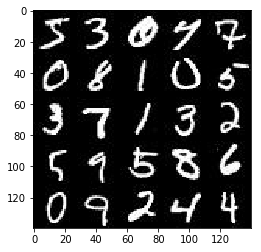

In [302]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

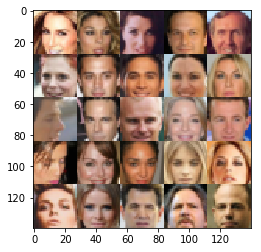

In [303]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [304]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/JasonX/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [305]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [306]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    n_units = 128
    alpha = 0.01
    # alpha = 0.05
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.contrib.layers.flatten(x3)
        # flat = tf.contrib.layers.flatten(x2)
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [307]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    # alpha = 0.05
    # print(z.get_shape())
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        # print(x1.get_shape())
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # print(x3.get_shape())
        
        # output layer should be 28x28x3
        # logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # print(logits.get_shape())
        
        out = tf.tanh(logits)
        # print(out)
        # print(out.get_shape())
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [308]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # debug
    # print(g_model.get_shape())
    # print(d_model_real.get_shape())
    # print(d_model_fake.get_shape())

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [309]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [310]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [311]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)
print(type(mnist_dataset.shape))

(60000, 28, 28, 1)
<class 'tuple'>


In [312]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    
    n_images = 25
    
    print("data_shape = {}".format(data_shape))
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # print(np.array(batch_images[0]))
                # print(np.amax(np.array(batch_images[0])))
                # print(np.amin(np.array(batch_images[0])))
                
                # normalize input to [-1, 1] from [-0.5, 0.5]
                batch_images = batch_images*2
                total_steps = data_shape[0]//batch_size
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, inputs_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}/{}...".format(steps, total_steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0 or steps == total_steps:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
    
    return None 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

data_shape = (60000, 28, 28, 1)
Epoch 1/2... Batch 20/1875... Discriminator Loss: 1.8912... Generator Loss: 5.5852
Epoch 1/2... Batch 40/1875... Discriminator Loss: 2.5876... Generator Loss: 0.1164
Epoch 1/2... Batch 60/1875... Discriminator Loss: 2.2295... Generator Loss: 0.1345
Epoch 1/2... Batch 80/1875... Discriminator Loss: 1.7005... Generator Loss: 0.2624
Epoch 1/2... Batch 100/1875... Discriminator Loss: 1.4487... Generator Loss: 0.3384


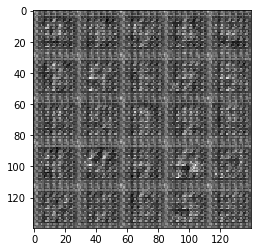

Epoch 1/2... Batch 120/1875... Discriminator Loss: 1.2044... Generator Loss: 0.4980
Epoch 1/2... Batch 140/1875... Discriminator Loss: 1.3303... Generator Loss: 0.4200
Epoch 1/2... Batch 160/1875... Discriminator Loss: 0.9577... Generator Loss: 0.8446
Epoch 1/2... Batch 180/1875... Discriminator Loss: 1.5268... Generator Loss: 0.3218
Epoch 1/2... Batch 200/1875... Discriminator Loss: 1.9419... Generator Loss: 2.6622


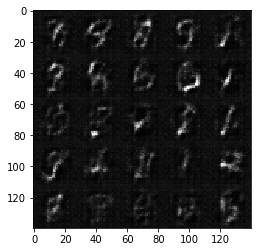

Epoch 1/2... Batch 220/1875... Discriminator Loss: 2.0052... Generator Loss: 0.1923
Epoch 1/2... Batch 240/1875... Discriminator Loss: 1.5367... Generator Loss: 0.3602
Epoch 1/2... Batch 260/1875... Discriminator Loss: 2.3246... Generator Loss: 0.1222
Epoch 1/2... Batch 280/1875... Discriminator Loss: 0.9230... Generator Loss: 1.0117
Epoch 1/2... Batch 300/1875... Discriminator Loss: 1.7547... Generator Loss: 0.2657


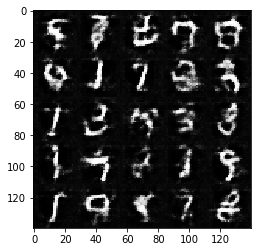

Epoch 1/2... Batch 320/1875... Discriminator Loss: 0.9201... Generator Loss: 1.0791
Epoch 1/2... Batch 340/1875... Discriminator Loss: 1.3413... Generator Loss: 0.4274
Epoch 1/2... Batch 360/1875... Discriminator Loss: 1.2148... Generator Loss: 0.4951
Epoch 1/2... Batch 380/1875... Discriminator Loss: 1.4443... Generator Loss: 0.3839
Epoch 1/2... Batch 400/1875... Discriminator Loss: 1.0140... Generator Loss: 1.1346


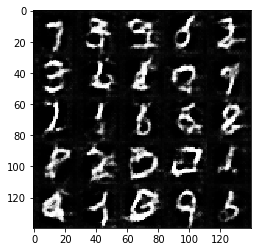

Epoch 1/2... Batch 420/1875... Discriminator Loss: 0.9530... Generator Loss: 0.7282
Epoch 1/2... Batch 440/1875... Discriminator Loss: 2.1868... Generator Loss: 0.1629
Epoch 1/2... Batch 460/1875... Discriminator Loss: 0.9417... Generator Loss: 0.9960
Epoch 1/2... Batch 480/1875... Discriminator Loss: 0.8797... Generator Loss: 1.0002
Epoch 1/2... Batch 500/1875... Discriminator Loss: 1.6898... Generator Loss: 0.3445


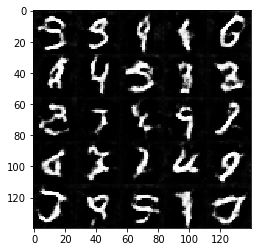

Epoch 1/2... Batch 520/1875... Discriminator Loss: 0.7205... Generator Loss: 0.8983
Epoch 1/2... Batch 540/1875... Discriminator Loss: 1.2501... Generator Loss: 0.5086
Epoch 1/2... Batch 560/1875... Discriminator Loss: 0.9701... Generator Loss: 1.3445
Epoch 1/2... Batch 580/1875... Discriminator Loss: 1.0160... Generator Loss: 0.6784
Epoch 1/2... Batch 600/1875... Discriminator Loss: 1.3771... Generator Loss: 0.4454


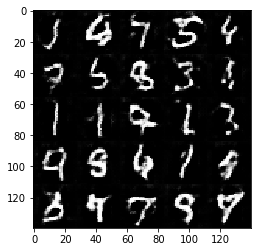

Epoch 1/2... Batch 620/1875... Discriminator Loss: 1.0767... Generator Loss: 0.5955
Epoch 1/2... Batch 640/1875... Discriminator Loss: 0.8026... Generator Loss: 1.6364
Epoch 1/2... Batch 660/1875... Discriminator Loss: 0.6996... Generator Loss: 1.2489
Epoch 1/2... Batch 680/1875... Discriminator Loss: 1.2029... Generator Loss: 0.5444
Epoch 1/2... Batch 700/1875... Discriminator Loss: 0.4990... Generator Loss: 1.4892


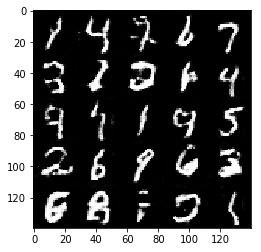

Epoch 1/2... Batch 720/1875... Discriminator Loss: 0.7574... Generator Loss: 0.9561
Epoch 1/2... Batch 740/1875... Discriminator Loss: 0.8377... Generator Loss: 2.5325
Epoch 1/2... Batch 760/1875... Discriminator Loss: 0.4892... Generator Loss: 1.9163
Epoch 1/2... Batch 780/1875... Discriminator Loss: 1.4338... Generator Loss: 0.3553
Epoch 1/2... Batch 800/1875... Discriminator Loss: 1.5092... Generator Loss: 0.3250


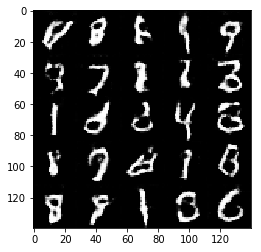

Epoch 1/2... Batch 820/1875... Discriminator Loss: 1.5273... Generator Loss: 0.3653
Epoch 1/2... Batch 840/1875... Discriminator Loss: 0.4886... Generator Loss: 1.7940
Epoch 1/2... Batch 860/1875... Discriminator Loss: 0.6785... Generator Loss: 2.1578
Epoch 1/2... Batch 880/1875... Discriminator Loss: 1.1454... Generator Loss: 0.5548
Epoch 1/2... Batch 900/1875... Discriminator Loss: 0.9208... Generator Loss: 0.7409


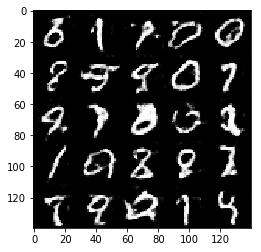

Epoch 1/2... Batch 920/1875... Discriminator Loss: 0.8833... Generator Loss: 1.6443
Epoch 1/2... Batch 940/1875... Discriminator Loss: 0.8681... Generator Loss: 0.9181
Epoch 1/2... Batch 960/1875... Discriminator Loss: 0.5623... Generator Loss: 1.4732
Epoch 1/2... Batch 980/1875... Discriminator Loss: 0.5963... Generator Loss: 1.2468
Epoch 1/2... Batch 1000/1875... Discriminator Loss: 0.6201... Generator Loss: 1.2518


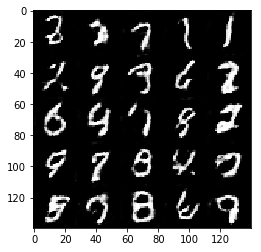

Epoch 1/2... Batch 1020/1875... Discriminator Loss: 3.3808... Generator Loss: 0.0639
Epoch 1/2... Batch 1040/1875... Discriminator Loss: 0.6282... Generator Loss: 1.2580
Epoch 1/2... Batch 1060/1875... Discriminator Loss: 1.7953... Generator Loss: 0.3457
Epoch 1/2... Batch 1080/1875... Discriminator Loss: 1.4219... Generator Loss: 0.4009
Epoch 1/2... Batch 1100/1875... Discriminator Loss: 1.4688... Generator Loss: 0.3543


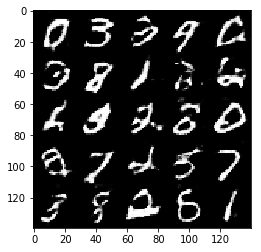

Epoch 1/2... Batch 1120/1875... Discriminator Loss: 0.6770... Generator Loss: 1.1358
Epoch 1/2... Batch 1140/1875... Discriminator Loss: 1.5019... Generator Loss: 0.3232
Epoch 1/2... Batch 1160/1875... Discriminator Loss: 0.7378... Generator Loss: 1.0147
Epoch 1/2... Batch 1180/1875... Discriminator Loss: 1.0818... Generator Loss: 0.5883
Epoch 1/2... Batch 1200/1875... Discriminator Loss: 0.5502... Generator Loss: 1.2918


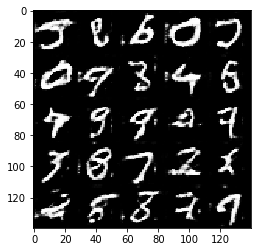

Epoch 1/2... Batch 1220/1875... Discriminator Loss: 1.1127... Generator Loss: 2.9255
Epoch 1/2... Batch 1240/1875... Discriminator Loss: 0.6820... Generator Loss: 0.9791
Epoch 1/2... Batch 1260/1875... Discriminator Loss: 0.6581... Generator Loss: 0.9994
Epoch 1/2... Batch 1280/1875... Discriminator Loss: 0.7362... Generator Loss: 0.8810
Epoch 1/2... Batch 1300/1875... Discriminator Loss: 0.6001... Generator Loss: 1.2004


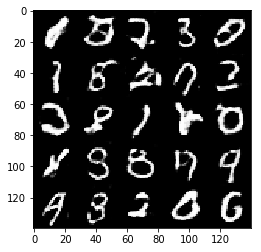

Epoch 1/2... Batch 1320/1875... Discriminator Loss: 0.5393... Generator Loss: 1.3285
Epoch 1/2... Batch 1340/1875... Discriminator Loss: 0.7472... Generator Loss: 0.9728
Epoch 1/2... Batch 1360/1875... Discriminator Loss: 2.6070... Generator Loss: 0.1131
Epoch 1/2... Batch 1380/1875... Discriminator Loss: 0.3495... Generator Loss: 2.0042
Epoch 1/2... Batch 1400/1875... Discriminator Loss: 1.2209... Generator Loss: 0.4502


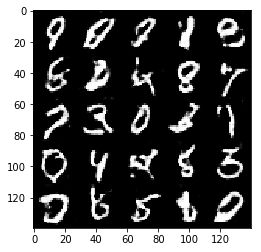

Epoch 1/2... Batch 1420/1875... Discriminator Loss: 1.0227... Generator Loss: 0.6396
Epoch 1/2... Batch 1440/1875... Discriminator Loss: 0.5346... Generator Loss: 1.3636
Epoch 1/2... Batch 1460/1875... Discriminator Loss: 0.3303... Generator Loss: 1.6734
Epoch 1/2... Batch 1480/1875... Discriminator Loss: 0.9458... Generator Loss: 0.7418
Epoch 1/2... Batch 1500/1875... Discriminator Loss: 0.6415... Generator Loss: 1.1414


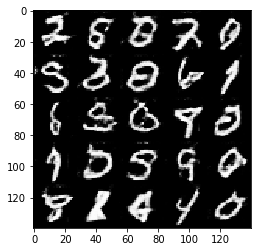

Epoch 1/2... Batch 1520/1875... Discriminator Loss: 1.4408... Generator Loss: 0.4549
Epoch 1/2... Batch 1540/1875... Discriminator Loss: 0.6969... Generator Loss: 1.0157
Epoch 1/2... Batch 1560/1875... Discriminator Loss: 0.9029... Generator Loss: 0.8184
Epoch 1/2... Batch 1580/1875... Discriminator Loss: 0.8182... Generator Loss: 1.3432
Epoch 1/2... Batch 1600/1875... Discriminator Loss: 1.5203... Generator Loss: 0.4101


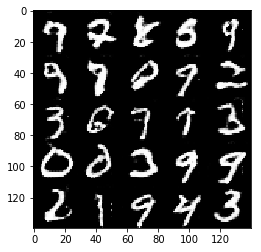

Epoch 1/2... Batch 1620/1875... Discriminator Loss: 2.2762... Generator Loss: 0.1657
Epoch 1/2... Batch 1640/1875... Discriminator Loss: 0.6784... Generator Loss: 1.1372
Epoch 1/2... Batch 1660/1875... Discriminator Loss: 0.8261... Generator Loss: 0.8763
Epoch 1/2... Batch 1680/1875... Discriminator Loss: 0.3865... Generator Loss: 1.7107
Epoch 1/2... Batch 1700/1875... Discriminator Loss: 0.4502... Generator Loss: 1.7864


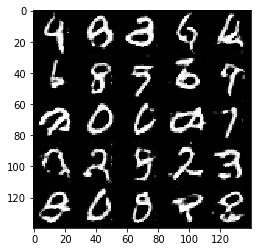

Epoch 1/2... Batch 1720/1875... Discriminator Loss: 0.9893... Generator Loss: 3.0634
Epoch 1/2... Batch 1740/1875... Discriminator Loss: 0.4766... Generator Loss: 1.8599
Epoch 1/2... Batch 1760/1875... Discriminator Loss: 1.3719... Generator Loss: 0.4206
Epoch 1/2... Batch 1780/1875... Discriminator Loss: 1.0587... Generator Loss: 3.6860
Epoch 1/2... Batch 1800/1875... Discriminator Loss: 0.4954... Generator Loss: 1.3147


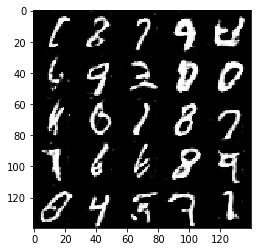

Epoch 1/2... Batch 1820/1875... Discriminator Loss: 0.8963... Generator Loss: 0.7582
Epoch 1/2... Batch 1840/1875... Discriminator Loss: 1.4377... Generator Loss: 0.4051
Epoch 1/2... Batch 1860/1875... Discriminator Loss: 2.6227... Generator Loss: 0.1531


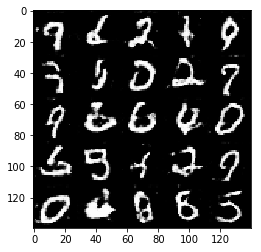

Epoch 2/2... Batch 20/1875... Discriminator Loss: 1.1133... Generator Loss: 0.5117
Epoch 2/2... Batch 40/1875... Discriminator Loss: 0.4457... Generator Loss: 1.3937
Epoch 2/2... Batch 60/1875... Discriminator Loss: 0.8284... Generator Loss: 0.7883
Epoch 2/2... Batch 80/1875... Discriminator Loss: 0.5385... Generator Loss: 2.3160
Epoch 2/2... Batch 100/1875... Discriminator Loss: 0.2959... Generator Loss: 2.6448


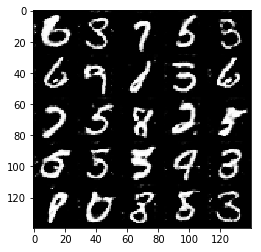

Epoch 2/2... Batch 120/1875... Discriminator Loss: 0.5664... Generator Loss: 1.2105
Epoch 2/2... Batch 140/1875... Discriminator Loss: 0.9630... Generator Loss: 0.6514
Epoch 2/2... Batch 160/1875... Discriminator Loss: 0.3412... Generator Loss: 1.8426
Epoch 2/2... Batch 180/1875... Discriminator Loss: 0.7619... Generator Loss: 0.8468
Epoch 2/2... Batch 200/1875... Discriminator Loss: 0.3888... Generator Loss: 1.5319


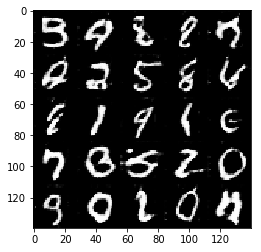

Epoch 2/2... Batch 220/1875... Discriminator Loss: 0.3326... Generator Loss: 2.1541
Epoch 2/2... Batch 240/1875... Discriminator Loss: 1.9218... Generator Loss: 0.2805
Epoch 2/2... Batch 260/1875... Discriminator Loss: 0.5162... Generator Loss: 1.2819
Epoch 2/2... Batch 280/1875... Discriminator Loss: 0.5615... Generator Loss: 1.1012
Epoch 2/2... Batch 300/1875... Discriminator Loss: 0.7900... Generator Loss: 0.9555


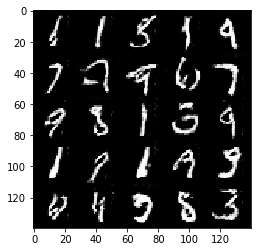

Epoch 2/2... Batch 320/1875... Discriminator Loss: 0.9456... Generator Loss: 0.7783
Epoch 2/2... Batch 340/1875... Discriminator Loss: 0.5852... Generator Loss: 1.3011
Epoch 2/2... Batch 360/1875... Discriminator Loss: 0.9121... Generator Loss: 0.6941
Epoch 2/2... Batch 380/1875... Discriminator Loss: 0.4145... Generator Loss: 1.4650
Epoch 2/2... Batch 400/1875... Discriminator Loss: 0.5263... Generator Loss: 1.2188


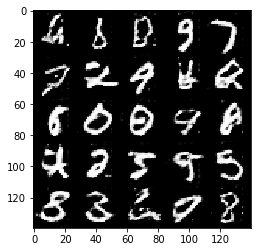

Epoch 2/2... Batch 420/1875... Discriminator Loss: 0.3704... Generator Loss: 1.8080
Epoch 2/2... Batch 440/1875... Discriminator Loss: 0.7064... Generator Loss: 1.0676
Epoch 2/2... Batch 460/1875... Discriminator Loss: 0.8238... Generator Loss: 0.8460
Epoch 2/2... Batch 480/1875... Discriminator Loss: 0.6132... Generator Loss: 2.8367
Epoch 2/2... Batch 500/1875... Discriminator Loss: 0.8211... Generator Loss: 0.7938


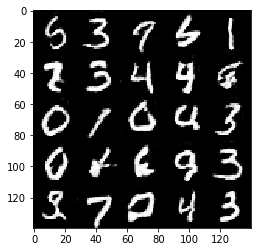

Epoch 2/2... Batch 520/1875... Discriminator Loss: 0.2745... Generator Loss: 2.6730
Epoch 2/2... Batch 540/1875... Discriminator Loss: 0.9814... Generator Loss: 0.6666
Epoch 2/2... Batch 560/1875... Discriminator Loss: 1.1549... Generator Loss: 4.8106
Epoch 2/2... Batch 580/1875... Discriminator Loss: 0.5445... Generator Loss: 4.5435
Epoch 2/2... Batch 600/1875... Discriminator Loss: 1.3589... Generator Loss: 4.2949


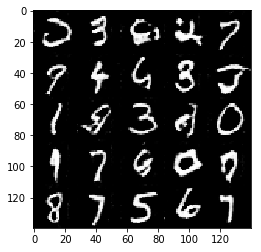

Epoch 2/2... Batch 620/1875... Discriminator Loss: 1.6915... Generator Loss: 0.3411
Epoch 2/2... Batch 640/1875... Discriminator Loss: 0.5751... Generator Loss: 1.3345
Epoch 2/2... Batch 660/1875... Discriminator Loss: 2.7682... Generator Loss: 0.1187
Epoch 2/2... Batch 680/1875... Discriminator Loss: 0.5391... Generator Loss: 1.2663
Epoch 2/2... Batch 700/1875... Discriminator Loss: 0.2599... Generator Loss: 2.5283


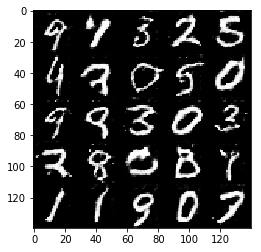

Epoch 2/2... Batch 720/1875... Discriminator Loss: 0.8450... Generator Loss: 0.7550
Epoch 2/2... Batch 740/1875... Discriminator Loss: 0.3099... Generator Loss: 2.3045
Epoch 2/2... Batch 760/1875... Discriminator Loss: 0.2307... Generator Loss: 1.9435
Epoch 2/2... Batch 780/1875... Discriminator Loss: 0.2442... Generator Loss: 2.2460
Epoch 2/2... Batch 800/1875... Discriminator Loss: 1.2293... Generator Loss: 0.5281


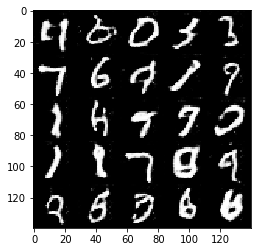

Epoch 2/2... Batch 820/1875... Discriminator Loss: 0.8065... Generator Loss: 0.8791
Epoch 2/2... Batch 840/1875... Discriminator Loss: 0.2626... Generator Loss: 2.0231
Epoch 2/2... Batch 860/1875... Discriminator Loss: 0.4801... Generator Loss: 1.9507
Epoch 2/2... Batch 880/1875... Discriminator Loss: 0.8122... Generator Loss: 0.8943
Epoch 2/2... Batch 900/1875... Discriminator Loss: 0.4598... Generator Loss: 1.3336


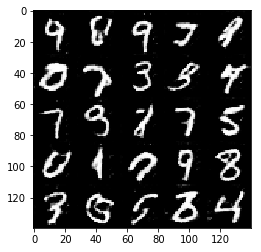

Epoch 2/2... Batch 920/1875... Discriminator Loss: 0.2859... Generator Loss: 3.1317
Epoch 2/2... Batch 940/1875... Discriminator Loss: 1.8936... Generator Loss: 0.3501
Epoch 2/2... Batch 960/1875... Discriminator Loss: 0.4401... Generator Loss: 1.3331
Epoch 2/2... Batch 980/1875... Discriminator Loss: 0.5216... Generator Loss: 1.3244
Epoch 2/2... Batch 1000/1875... Discriminator Loss: 0.3204... Generator Loss: 1.8162


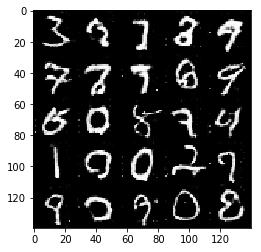

Epoch 2/2... Batch 1020/1875... Discriminator Loss: 0.4478... Generator Loss: 2.9879
Epoch 2/2... Batch 1040/1875... Discriminator Loss: 0.8112... Generator Loss: 0.8049
Epoch 2/2... Batch 1060/1875... Discriminator Loss: 0.8842... Generator Loss: 0.8261
Epoch 2/2... Batch 1080/1875... Discriminator Loss: 0.8324... Generator Loss: 0.8711
Epoch 2/2... Batch 1100/1875... Discriminator Loss: 1.0470... Generator Loss: 0.8731


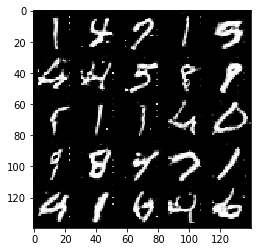

Epoch 2/2... Batch 1120/1875... Discriminator Loss: 0.3036... Generator Loss: 1.8119
Epoch 2/2... Batch 1140/1875... Discriminator Loss: 0.4835... Generator Loss: 1.4450
Epoch 2/2... Batch 1160/1875... Discriminator Loss: 0.5282... Generator Loss: 1.3807
Epoch 2/2... Batch 1180/1875... Discriminator Loss: 0.3449... Generator Loss: 1.9358
Epoch 2/2... Batch 1200/1875... Discriminator Loss: 0.1914... Generator Loss: 2.5152


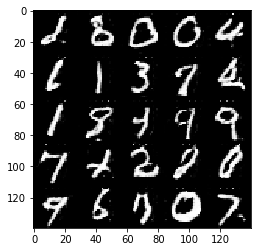

Epoch 2/2... Batch 1220/1875... Discriminator Loss: 1.4930... Generator Loss: 4.1064
Epoch 2/2... Batch 1240/1875... Discriminator Loss: 0.3839... Generator Loss: 1.5911
Epoch 2/2... Batch 1260/1875... Discriminator Loss: 0.2489... Generator Loss: 3.4526
Epoch 2/2... Batch 1280/1875... Discriminator Loss: 0.2129... Generator Loss: 2.5425
Epoch 2/2... Batch 1300/1875... Discriminator Loss: 1.5626... Generator Loss: 0.3778


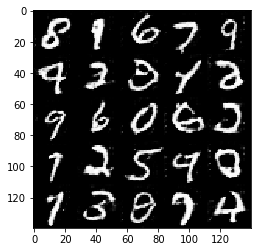

Epoch 2/2... Batch 1320/1875... Discriminator Loss: 0.7488... Generator Loss: 0.9879
Epoch 2/2... Batch 1340/1875... Discriminator Loss: 0.3783... Generator Loss: 1.5663
Epoch 2/2... Batch 1360/1875... Discriminator Loss: 2.0770... Generator Loss: 0.2904
Epoch 2/2... Batch 1380/1875... Discriminator Loss: 0.3683... Generator Loss: 1.5569
Epoch 2/2... Batch 1400/1875... Discriminator Loss: 0.6962... Generator Loss: 0.8713


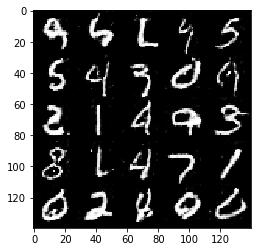

Epoch 2/2... Batch 1420/1875... Discriminator Loss: 1.3980... Generator Loss: 5.1085
Epoch 2/2... Batch 1440/1875... Discriminator Loss: 0.6474... Generator Loss: 1.0739
Epoch 2/2... Batch 1460/1875... Discriminator Loss: 0.3706... Generator Loss: 1.7553
Epoch 2/2... Batch 1480/1875... Discriminator Loss: 0.1304... Generator Loss: 2.8746
Epoch 2/2... Batch 1500/1875... Discriminator Loss: 0.4247... Generator Loss: 1.4171


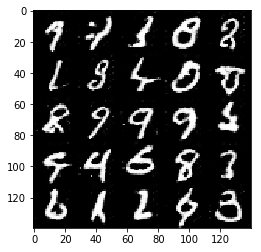

Epoch 2/2... Batch 1520/1875... Discriminator Loss: 0.2062... Generator Loss: 2.3334
Epoch 2/2... Batch 1540/1875... Discriminator Loss: 2.9027... Generator Loss: 0.1815
Epoch 2/2... Batch 1560/1875... Discriminator Loss: 0.3754... Generator Loss: 1.7324
Epoch 2/2... Batch 1580/1875... Discriminator Loss: 0.5203... Generator Loss: 1.2569
Epoch 2/2... Batch 1600/1875... Discriminator Loss: 0.6099... Generator Loss: 1.1102


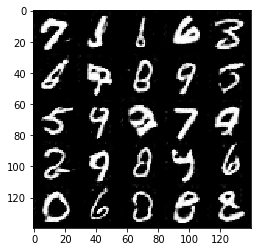

Epoch 2/2... Batch 1620/1875... Discriminator Loss: 2.1012... Generator Loss: 0.2214
Epoch 2/2... Batch 1640/1875... Discriminator Loss: 0.2400... Generator Loss: 2.2523
Epoch 2/2... Batch 1660/1875... Discriminator Loss: 0.3643... Generator Loss: 1.9589
Epoch 2/2... Batch 1680/1875... Discriminator Loss: 0.2139... Generator Loss: 2.0365
Epoch 2/2... Batch 1700/1875... Discriminator Loss: 0.4010... Generator Loss: 1.4881


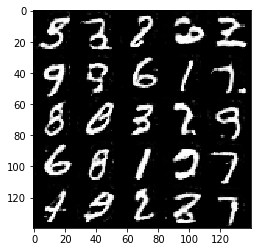

Epoch 2/2... Batch 1720/1875... Discriminator Loss: 0.4302... Generator Loss: 1.7576
Epoch 2/2... Batch 1740/1875... Discriminator Loss: 1.0024... Generator Loss: 4.2483
Epoch 2/2... Batch 1760/1875... Discriminator Loss: 0.5913... Generator Loss: 1.2454
Epoch 2/2... Batch 1780/1875... Discriminator Loss: 0.4267... Generator Loss: 1.4204
Epoch 2/2... Batch 1800/1875... Discriminator Loss: 0.4877... Generator Loss: 1.3758


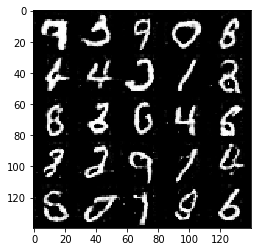

Epoch 2/2... Batch 1820/1875... Discriminator Loss: 0.2831... Generator Loss: 1.9293
Epoch 2/2... Batch 1840/1875... Discriminator Loss: 0.2806... Generator Loss: 2.0859
Epoch 2/2... Batch 1860/1875... Discriminator Loss: 3.2994... Generator Loss: 0.0616


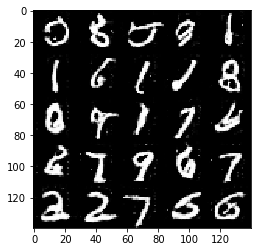

In [313]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

data_shape = (202599, 28, 28, 3)
Epoch 1/1... Batch 20/6331... Discriminator Loss: 4.2775... Generator Loss: 11.6319
Epoch 1/1... Batch 40/6331... Discriminator Loss: 1.4053... Generator Loss: 2.8931
Epoch 1/1... Batch 60/6331... Discriminator Loss: 0.9448... Generator Loss: 1.8022
Epoch 1/1... Batch 80/6331... Discriminator Loss: 0.9528... Generator Loss: 0.8566
Epoch 1/1... Batch 100/6331... Discriminator Loss: 1.7309... Generator Loss: 2.6118


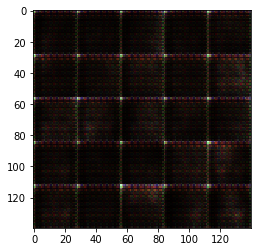

Epoch 1/1... Batch 120/6331... Discriminator Loss: 1.2093... Generator Loss: 0.5741
Epoch 1/1... Batch 140/6331... Discriminator Loss: 0.8415... Generator Loss: 1.4373
Epoch 1/1... Batch 160/6331... Discriminator Loss: 1.5089... Generator Loss: 0.3274
Epoch 1/1... Batch 180/6331... Discriminator Loss: 2.2845... Generator Loss: 0.1389
Epoch 1/1... Batch 200/6331... Discriminator Loss: 2.0963... Generator Loss: 0.1824


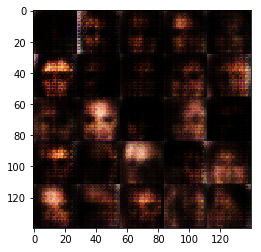

Epoch 1/1... Batch 220/6331... Discriminator Loss: 1.3218... Generator Loss: 2.0565
Epoch 1/1... Batch 240/6331... Discriminator Loss: 1.3311... Generator Loss: 1.3133
Epoch 1/1... Batch 260/6331... Discriminator Loss: 1.9246... Generator Loss: 2.9931
Epoch 1/1... Batch 280/6331... Discriminator Loss: 1.0998... Generator Loss: 1.2415
Epoch 1/1... Batch 300/6331... Discriminator Loss: 1.5606... Generator Loss: 1.6013


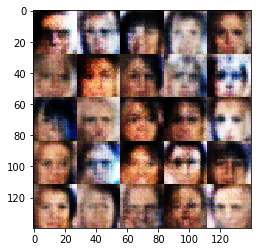

Epoch 1/1... Batch 320/6331... Discriminator Loss: 1.3335... Generator Loss: 1.7767
Epoch 1/1... Batch 340/6331... Discriminator Loss: 1.6972... Generator Loss: 2.5689
Epoch 1/1... Batch 360/6331... Discriminator Loss: 1.0384... Generator Loss: 0.6778
Epoch 1/1... Batch 380/6331... Discriminator Loss: 1.4860... Generator Loss: 0.4205
Epoch 1/1... Batch 400/6331... Discriminator Loss: 1.2808... Generator Loss: 0.6471


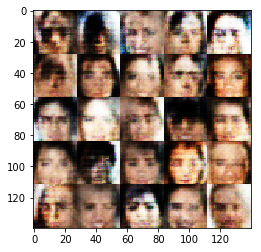

Epoch 1/1... Batch 420/6331... Discriminator Loss: 2.5125... Generator Loss: 2.3919
Epoch 1/1... Batch 440/6331... Discriminator Loss: 1.0375... Generator Loss: 0.7203
Epoch 1/1... Batch 460/6331... Discriminator Loss: 1.6336... Generator Loss: 0.2836
Epoch 1/1... Batch 480/6331... Discriminator Loss: 1.6627... Generator Loss: 0.2659
Epoch 1/1... Batch 500/6331... Discriminator Loss: 0.7654... Generator Loss: 1.3159


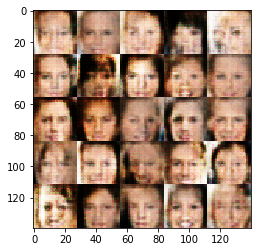

Epoch 1/1... Batch 520/6331... Discriminator Loss: 1.8542... Generator Loss: 0.2435
Epoch 1/1... Batch 540/6331... Discriminator Loss: 1.6841... Generator Loss: 0.3480
Epoch 1/1... Batch 560/6331... Discriminator Loss: 1.2707... Generator Loss: 1.0579
Epoch 1/1... Batch 580/6331... Discriminator Loss: 0.7667... Generator Loss: 0.9388
Epoch 1/1... Batch 600/6331... Discriminator Loss: 0.7083... Generator Loss: 1.0428


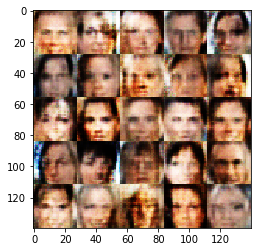

Epoch 1/1... Batch 620/6331... Discriminator Loss: 1.3036... Generator Loss: 2.5394
Epoch 1/1... Batch 640/6331... Discriminator Loss: 0.5861... Generator Loss: 1.0901
Epoch 1/1... Batch 660/6331... Discriminator Loss: 1.4483... Generator Loss: 0.5710
Epoch 1/1... Batch 680/6331... Discriminator Loss: 1.5266... Generator Loss: 1.6222
Epoch 1/1... Batch 700/6331... Discriminator Loss: 2.6132... Generator Loss: 0.0876


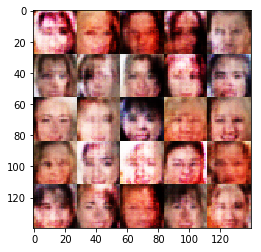

Epoch 1/1... Batch 720/6331... Discriminator Loss: 1.0744... Generator Loss: 1.1403
Epoch 1/1... Batch 740/6331... Discriminator Loss: 1.0666... Generator Loss: 0.5504
Epoch 1/1... Batch 760/6331... Discriminator Loss: 0.8031... Generator Loss: 0.8336
Epoch 1/1... Batch 780/6331... Discriminator Loss: 1.3287... Generator Loss: 0.4550
Epoch 1/1... Batch 800/6331... Discriminator Loss: 1.3791... Generator Loss: 0.3447


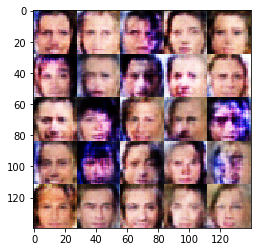

Epoch 1/1... Batch 820/6331... Discriminator Loss: 1.7039... Generator Loss: 0.2469
Epoch 1/1... Batch 840/6331... Discriminator Loss: 1.9529... Generator Loss: 2.1169
Epoch 1/1... Batch 860/6331... Discriminator Loss: 1.8842... Generator Loss: 0.2059
Epoch 1/1... Batch 880/6331... Discriminator Loss: 0.7744... Generator Loss: 0.7348
Epoch 1/1... Batch 900/6331... Discriminator Loss: 1.7340... Generator Loss: 1.9007


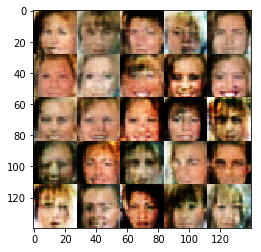

Epoch 1/1... Batch 920/6331... Discriminator Loss: 0.5622... Generator Loss: 3.6119
Epoch 1/1... Batch 940/6331... Discriminator Loss: 0.8060... Generator Loss: 0.9628
Epoch 1/1... Batch 960/6331... Discriminator Loss: 1.5954... Generator Loss: 0.3224
Epoch 1/1... Batch 980/6331... Discriminator Loss: 0.6883... Generator Loss: 1.4646
Epoch 1/1... Batch 1000/6331... Discriminator Loss: 0.9657... Generator Loss: 0.6858


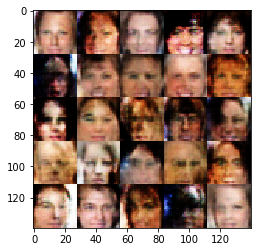

Epoch 1/1... Batch 1020/6331... Discriminator Loss: 0.7363... Generator Loss: 0.8962
Epoch 1/1... Batch 1040/6331... Discriminator Loss: 1.2078... Generator Loss: 0.5369
Epoch 1/1... Batch 1060/6331... Discriminator Loss: 1.2452... Generator Loss: 1.2298
Epoch 1/1... Batch 1080/6331... Discriminator Loss: 0.9747... Generator Loss: 0.5819
Epoch 1/1... Batch 1100/6331... Discriminator Loss: 2.0097... Generator Loss: 0.1897


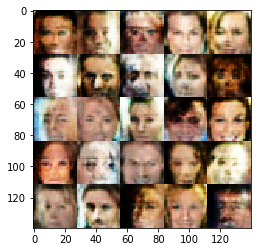

Epoch 1/1... Batch 1120/6331... Discriminator Loss: 1.0868... Generator Loss: 1.0472
Epoch 1/1... Batch 1140/6331... Discriminator Loss: 0.7891... Generator Loss: 0.7469
Epoch 1/1... Batch 1160/6331... Discriminator Loss: 1.0208... Generator Loss: 0.5597
Epoch 1/1... Batch 1180/6331... Discriminator Loss: 1.2128... Generator Loss: 0.6111
Epoch 1/1... Batch 1200/6331... Discriminator Loss: 2.1440... Generator Loss: 0.1594


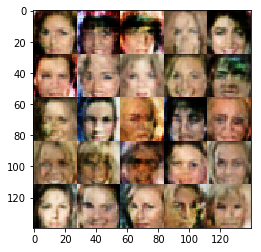

Epoch 1/1... Batch 1220/6331... Discriminator Loss: 1.2200... Generator Loss: 0.6704
Epoch 1/1... Batch 1240/6331... Discriminator Loss: 0.6385... Generator Loss: 0.9979
Epoch 1/1... Batch 1260/6331... Discriminator Loss: 1.8178... Generator Loss: 0.2361
Epoch 1/1... Batch 1280/6331... Discriminator Loss: 1.4079... Generator Loss: 0.5521
Epoch 1/1... Batch 1300/6331... Discriminator Loss: 0.6255... Generator Loss: 2.4350


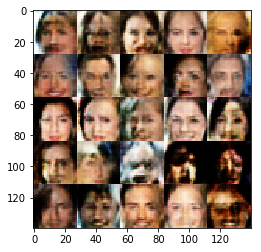

Epoch 1/1... Batch 1320/6331... Discriminator Loss: 1.1769... Generator Loss: 1.0056
Epoch 1/1... Batch 1340/6331... Discriminator Loss: 1.0810... Generator Loss: 0.8065
Epoch 1/1... Batch 1360/6331... Discriminator Loss: 1.3640... Generator Loss: 0.4176
Epoch 1/1... Batch 1380/6331... Discriminator Loss: 0.9185... Generator Loss: 0.6716
Epoch 1/1... Batch 1400/6331... Discriminator Loss: 0.7644... Generator Loss: 0.8490


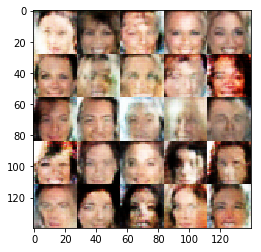

Epoch 1/1... Batch 1420/6331... Discriminator Loss: 0.7427... Generator Loss: 1.5782
Epoch 1/1... Batch 1440/6331... Discriminator Loss: 1.4334... Generator Loss: 2.1477
Epoch 1/1... Batch 1460/6331... Discriminator Loss: 1.9981... Generator Loss: 0.1680
Epoch 1/1... Batch 1480/6331... Discriminator Loss: 0.6001... Generator Loss: 1.6097
Epoch 1/1... Batch 1500/6331... Discriminator Loss: 0.8544... Generator Loss: 0.9609


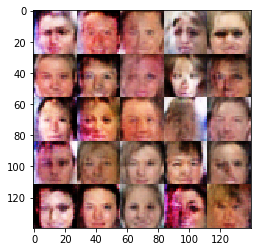

Epoch 1/1... Batch 1520/6331... Discriminator Loss: 0.7191... Generator Loss: 1.5854
Epoch 1/1... Batch 1540/6331... Discriminator Loss: 1.2405... Generator Loss: 1.3131
Epoch 1/1... Batch 1560/6331... Discriminator Loss: 0.6116... Generator Loss: 1.9374
Epoch 1/1... Batch 1580/6331... Discriminator Loss: 1.4471... Generator Loss: 0.3824
Epoch 1/1... Batch 1600/6331... Discriminator Loss: 1.9456... Generator Loss: 0.2141


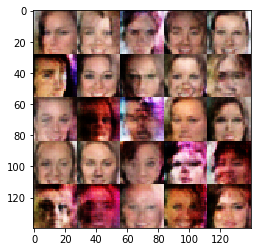

Epoch 1/1... Batch 1620/6331... Discriminator Loss: 1.4135... Generator Loss: 0.3326
Epoch 1/1... Batch 1640/6331... Discriminator Loss: 0.7021... Generator Loss: 1.0098
Epoch 1/1... Batch 1660/6331... Discriminator Loss: 1.1088... Generator Loss: 1.5809
Epoch 1/1... Batch 1680/6331... Discriminator Loss: 2.4309... Generator Loss: 0.1155
Epoch 1/1... Batch 1700/6331... Discriminator Loss: 1.5425... Generator Loss: 0.4412


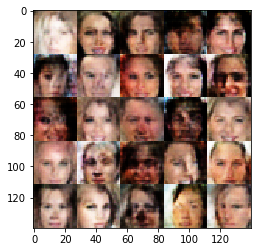

Epoch 1/1... Batch 1720/6331... Discriminator Loss: 1.2954... Generator Loss: 0.6136
Epoch 1/1... Batch 1740/6331... Discriminator Loss: 2.1592... Generator Loss: 0.1468
Epoch 1/1... Batch 1760/6331... Discriminator Loss: 1.2617... Generator Loss: 0.4493
Epoch 1/1... Batch 1780/6331... Discriminator Loss: 0.9806... Generator Loss: 0.7064
Epoch 1/1... Batch 1800/6331... Discriminator Loss: 1.2142... Generator Loss: 0.5533


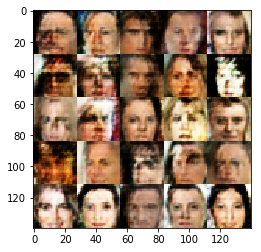

Epoch 1/1... Batch 1820/6331... Discriminator Loss: 1.3699... Generator Loss: 0.4017
Epoch 1/1... Batch 1840/6331... Discriminator Loss: 1.2005... Generator Loss: 0.7087
Epoch 1/1... Batch 1860/6331... Discriminator Loss: 0.9104... Generator Loss: 0.9884
Epoch 1/1... Batch 1880/6331... Discriminator Loss: 0.6713... Generator Loss: 1.2581
Epoch 1/1... Batch 1900/6331... Discriminator Loss: 1.7362... Generator Loss: 0.2411


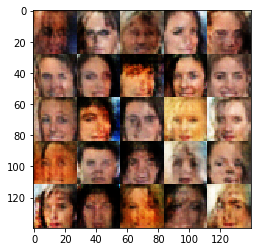

Epoch 1/1... Batch 1920/6331... Discriminator Loss: 1.2424... Generator Loss: 0.6707
Epoch 1/1... Batch 1940/6331... Discriminator Loss: 1.4535... Generator Loss: 1.3355
Epoch 1/1... Batch 1960/6331... Discriminator Loss: 1.3979... Generator Loss: 0.3915
Epoch 1/1... Batch 1980/6331... Discriminator Loss: 1.9744... Generator Loss: 0.1884
Epoch 1/1... Batch 2000/6331... Discriminator Loss: 1.1366... Generator Loss: 0.5375


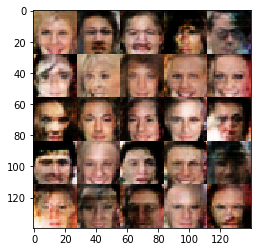

Epoch 1/1... Batch 2020/6331... Discriminator Loss: 1.3384... Generator Loss: 0.5326
Epoch 1/1... Batch 2040/6331... Discriminator Loss: 1.7236... Generator Loss: 2.8826
Epoch 1/1... Batch 2060/6331... Discriminator Loss: 1.1014... Generator Loss: 1.8954
Epoch 1/1... Batch 2080/6331... Discriminator Loss: 1.2637... Generator Loss: 0.7087
Epoch 1/1... Batch 2100/6331... Discriminator Loss: 0.5538... Generator Loss: 1.0773


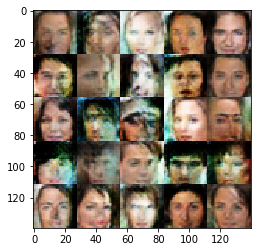

Epoch 1/1... Batch 2120/6331... Discriminator Loss: 1.6091... Generator Loss: 0.3173
Epoch 1/1... Batch 2140/6331... Discriminator Loss: 1.0381... Generator Loss: 1.4245
Epoch 1/1... Batch 2160/6331... Discriminator Loss: 1.2169... Generator Loss: 1.5286
Epoch 1/1... Batch 2180/6331... Discriminator Loss: 0.7996... Generator Loss: 0.7574
Epoch 1/1... Batch 2200/6331... Discriminator Loss: 2.2766... Generator Loss: 0.1250


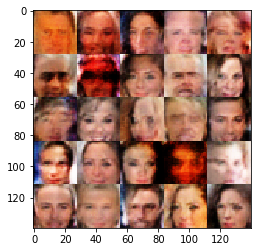

Epoch 1/1... Batch 2220/6331... Discriminator Loss: 1.1675... Generator Loss: 0.4866
Epoch 1/1... Batch 2240/6331... Discriminator Loss: 1.6642... Generator Loss: 0.2535
Epoch 1/1... Batch 2260/6331... Discriminator Loss: 2.4830... Generator Loss: 0.1046
Epoch 1/1... Batch 2280/6331... Discriminator Loss: 1.7304... Generator Loss: 0.3875
Epoch 1/1... Batch 2300/6331... Discriminator Loss: 2.3025... Generator Loss: 0.1288


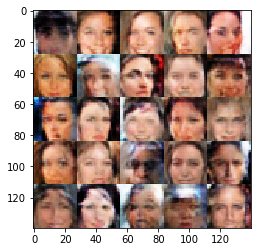

Epoch 1/1... Batch 2320/6331... Discriminator Loss: 0.8111... Generator Loss: 0.9731
Epoch 1/1... Batch 2340/6331... Discriminator Loss: 1.6467... Generator Loss: 0.2588
Epoch 1/1... Batch 2360/6331... Discriminator Loss: 0.9352... Generator Loss: 0.8598
Epoch 1/1... Batch 2380/6331... Discriminator Loss: 1.4122... Generator Loss: 0.4870
Epoch 1/1... Batch 2400/6331... Discriminator Loss: 0.9962... Generator Loss: 0.7762


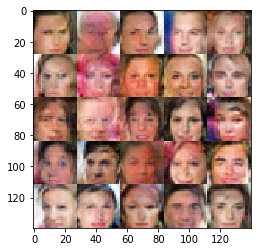

Epoch 1/1... Batch 2420/6331... Discriminator Loss: 1.1081... Generator Loss: 0.6277
Epoch 1/1... Batch 2440/6331... Discriminator Loss: 2.4099... Generator Loss: 0.1200
Epoch 1/1... Batch 2460/6331... Discriminator Loss: 1.2195... Generator Loss: 0.4860
Epoch 1/1... Batch 2480/6331... Discriminator Loss: 1.2305... Generator Loss: 0.5913
Epoch 1/1... Batch 2500/6331... Discriminator Loss: 1.1786... Generator Loss: 0.5435


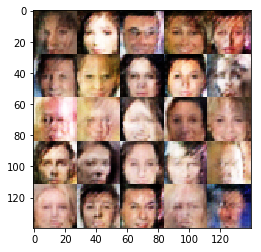

Epoch 1/1... Batch 2520/6331... Discriminator Loss: 1.4239... Generator Loss: 0.4765
Epoch 1/1... Batch 2540/6331... Discriminator Loss: 2.3265... Generator Loss: 0.1256
Epoch 1/1... Batch 2560/6331... Discriminator Loss: 1.4418... Generator Loss: 0.3539
Epoch 1/1... Batch 2580/6331... Discriminator Loss: 1.4110... Generator Loss: 0.4123
Epoch 1/1... Batch 2600/6331... Discriminator Loss: 1.2866... Generator Loss: 0.7025


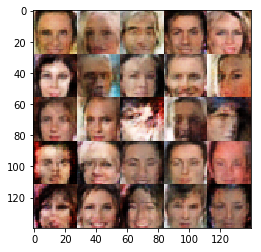

Epoch 1/1... Batch 2620/6331... Discriminator Loss: 1.1253... Generator Loss: 0.5758
Epoch 1/1... Batch 2640/6331... Discriminator Loss: 0.6628... Generator Loss: 0.9115
Epoch 1/1... Batch 2660/6331... Discriminator Loss: 0.9280... Generator Loss: 0.6765
Epoch 1/1... Batch 2680/6331... Discriminator Loss: 1.2979... Generator Loss: 0.8461
Epoch 1/1... Batch 2700/6331... Discriminator Loss: 0.8997... Generator Loss: 1.1059


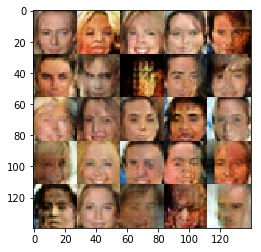

Epoch 1/1... Batch 2720/6331... Discriminator Loss: 0.8026... Generator Loss: 0.8301
Epoch 1/1... Batch 2740/6331... Discriminator Loss: 1.1511... Generator Loss: 2.2367
Epoch 1/1... Batch 2760/6331... Discriminator Loss: 0.6021... Generator Loss: 1.0275
Epoch 1/1... Batch 2780/6331... Discriminator Loss: 1.1316... Generator Loss: 0.5811
Epoch 1/1... Batch 2800/6331... Discriminator Loss: 1.8199... Generator Loss: 0.2092


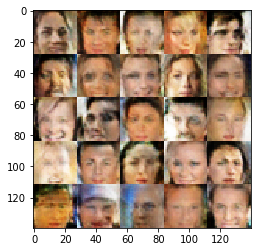

Epoch 1/1... Batch 2820/6331... Discriminator Loss: 0.9822... Generator Loss: 0.6078
Epoch 1/1... Batch 2840/6331... Discriminator Loss: 1.7219... Generator Loss: 0.3043
Epoch 1/1... Batch 2860/6331... Discriminator Loss: 1.5605... Generator Loss: 0.3049
Epoch 1/1... Batch 2880/6331... Discriminator Loss: 2.3232... Generator Loss: 0.1410
Epoch 1/1... Batch 2900/6331... Discriminator Loss: 2.1991... Generator Loss: 0.1621


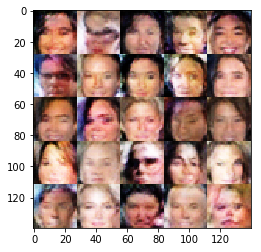

Epoch 1/1... Batch 2920/6331... Discriminator Loss: 1.9653... Generator Loss: 0.2014
Epoch 1/1... Batch 2940/6331... Discriminator Loss: 0.8656... Generator Loss: 1.1709
Epoch 1/1... Batch 2960/6331... Discriminator Loss: 1.4867... Generator Loss: 0.3600
Epoch 1/1... Batch 2980/6331... Discriminator Loss: 0.9843... Generator Loss: 0.9660
Epoch 1/1... Batch 3000/6331... Discriminator Loss: 1.7505... Generator Loss: 2.0202


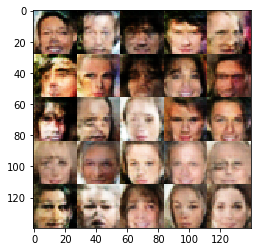

Epoch 1/1... Batch 3020/6331... Discriminator Loss: 0.9980... Generator Loss: 0.8242
Epoch 1/1... Batch 3040/6331... Discriminator Loss: 0.6877... Generator Loss: 0.9187
Epoch 1/1... Batch 3060/6331... Discriminator Loss: 1.2228... Generator Loss: 0.5663
Epoch 1/1... Batch 3080/6331... Discriminator Loss: 0.9967... Generator Loss: 0.6132
Epoch 1/1... Batch 3100/6331... Discriminator Loss: 2.8359... Generator Loss: 0.0814


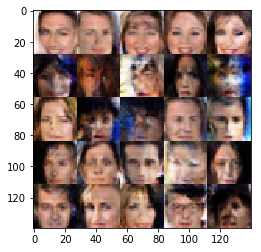

Epoch 1/1... Batch 3120/6331... Discriminator Loss: 2.1006... Generator Loss: 0.1610
Epoch 1/1... Batch 3140/6331... Discriminator Loss: 1.7789... Generator Loss: 0.2112
Epoch 1/1... Batch 3160/6331... Discriminator Loss: 0.6038... Generator Loss: 1.3110
Epoch 1/1... Batch 3180/6331... Discriminator Loss: 1.2633... Generator Loss: 0.6128
Epoch 1/1... Batch 3200/6331... Discriminator Loss: 1.0935... Generator Loss: 0.5906


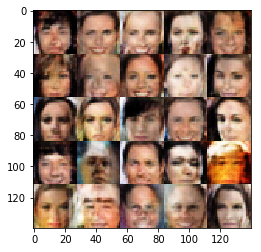

Epoch 1/1... Batch 3220/6331... Discriminator Loss: 0.8403... Generator Loss: 1.0175
Epoch 1/1... Batch 3240/6331... Discriminator Loss: 1.0061... Generator Loss: 1.3736
Epoch 1/1... Batch 3260/6331... Discriminator Loss: 0.3303... Generator Loss: 1.8539
Epoch 1/1... Batch 3280/6331... Discriminator Loss: 1.6489... Generator Loss: 2.1459
Epoch 1/1... Batch 3300/6331... Discriminator Loss: 1.6006... Generator Loss: 0.3147


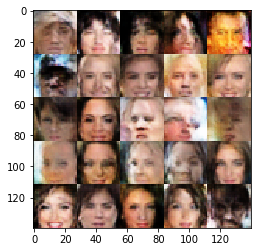

Epoch 1/1... Batch 3320/6331... Discriminator Loss: 0.5037... Generator Loss: 1.1709
Epoch 1/1... Batch 3340/6331... Discriminator Loss: 2.0387... Generator Loss: 0.1728
Epoch 1/1... Batch 3360/6331... Discriminator Loss: 1.0506... Generator Loss: 0.6610
Epoch 1/1... Batch 3380/6331... Discriminator Loss: 0.6580... Generator Loss: 1.7459
Epoch 1/1... Batch 3400/6331... Discriminator Loss: 0.4168... Generator Loss: 1.8391


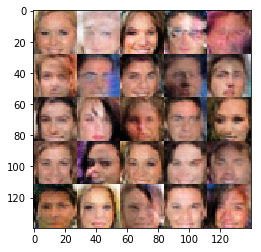

Epoch 1/1... Batch 3420/6331... Discriminator Loss: 0.1502... Generator Loss: 2.7772
Epoch 1/1... Batch 3440/6331... Discriminator Loss: 1.9114... Generator Loss: 0.2199
Epoch 1/1... Batch 3460/6331... Discriminator Loss: 1.3096... Generator Loss: 0.4307
Epoch 1/1... Batch 3480/6331... Discriminator Loss: 1.0107... Generator Loss: 1.2534
Epoch 1/1... Batch 3500/6331... Discriminator Loss: 1.2252... Generator Loss: 1.1318


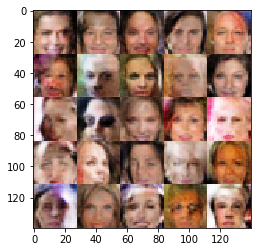

Epoch 1/1... Batch 3520/6331... Discriminator Loss: 1.1970... Generator Loss: 0.7277
Epoch 1/1... Batch 3540/6331... Discriminator Loss: 0.8988... Generator Loss: 0.7662
Epoch 1/1... Batch 3560/6331... Discriminator Loss: 0.7913... Generator Loss: 0.7451
Epoch 1/1... Batch 3580/6331... Discriminator Loss: 1.3459... Generator Loss: 0.6153
Epoch 1/1... Batch 3600/6331... Discriminator Loss: 1.0600... Generator Loss: 0.5559


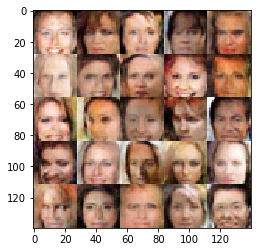

Epoch 1/1... Batch 3620/6331... Discriminator Loss: 1.5035... Generator Loss: 0.3287
Epoch 1/1... Batch 3640/6331... Discriminator Loss: 1.1761... Generator Loss: 0.5275
Epoch 1/1... Batch 3660/6331... Discriminator Loss: 0.7840... Generator Loss: 2.1309
Epoch 1/1... Batch 3680/6331... Discriminator Loss: 0.6523... Generator Loss: 1.0122
Epoch 1/1... Batch 3700/6331... Discriminator Loss: 1.5395... Generator Loss: 0.3759


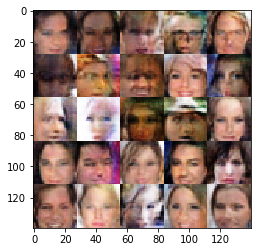

Epoch 1/1... Batch 3720/6331... Discriminator Loss: 0.7695... Generator Loss: 2.1377
Epoch 1/1... Batch 3740/6331... Discriminator Loss: 0.4763... Generator Loss: 2.0379
Epoch 1/1... Batch 3760/6331... Discriminator Loss: 1.1629... Generator Loss: 0.6214
Epoch 1/1... Batch 3780/6331... Discriminator Loss: 1.1171... Generator Loss: 0.5208
Epoch 1/1... Batch 3800/6331... Discriminator Loss: 1.4597... Generator Loss: 0.3694


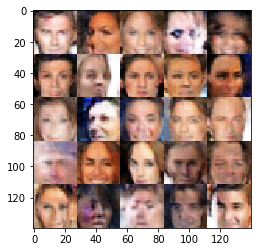

Epoch 1/1... Batch 3820/6331... Discriminator Loss: 1.2626... Generator Loss: 0.4539
Epoch 1/1... Batch 3840/6331... Discriminator Loss: 0.6067... Generator Loss: 1.2005
Epoch 1/1... Batch 3860/6331... Discriminator Loss: 2.3005... Generator Loss: 2.9164
Epoch 1/1... Batch 3880/6331... Discriminator Loss: 1.0961... Generator Loss: 1.0580
Epoch 1/1... Batch 3900/6331... Discriminator Loss: 0.7949... Generator Loss: 1.2422


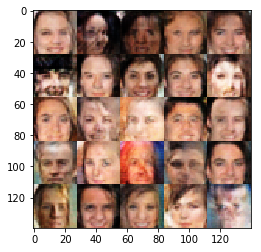

Epoch 1/1... Batch 3920/6331... Discriminator Loss: 0.8559... Generator Loss: 0.9403
Epoch 1/1... Batch 3940/6331... Discriminator Loss: 2.4936... Generator Loss: 0.1221
Epoch 1/1... Batch 3960/6331... Discriminator Loss: 0.6643... Generator Loss: 1.0476
Epoch 1/1... Batch 3980/6331... Discriminator Loss: 0.6756... Generator Loss: 1.0332
Epoch 1/1... Batch 4000/6331... Discriminator Loss: 1.0310... Generator Loss: 0.5592


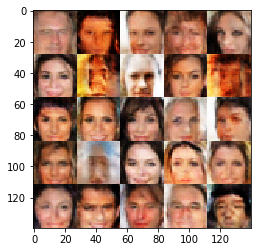

Epoch 1/1... Batch 4020/6331... Discriminator Loss: 1.0663... Generator Loss: 0.5891
Epoch 1/1... Batch 4040/6331... Discriminator Loss: 1.9453... Generator Loss: 0.2029
Epoch 1/1... Batch 4060/6331... Discriminator Loss: 0.9288... Generator Loss: 0.9853
Epoch 1/1... Batch 4080/6331... Discriminator Loss: 0.8523... Generator Loss: 4.4762
Epoch 1/1... Batch 4100/6331... Discriminator Loss: 1.4531... Generator Loss: 0.3578


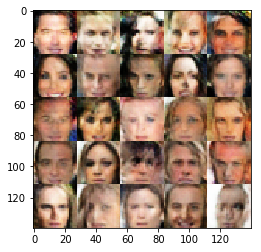

Epoch 1/1... Batch 4120/6331... Discriminator Loss: 1.2362... Generator Loss: 0.5188
Epoch 1/1... Batch 4140/6331... Discriminator Loss: 0.7265... Generator Loss: 0.8669
Epoch 1/1... Batch 4160/6331... Discriminator Loss: 2.0780... Generator Loss: 0.1749
Epoch 1/1... Batch 4180/6331... Discriminator Loss: 1.0622... Generator Loss: 0.5682
Epoch 1/1... Batch 4200/6331... Discriminator Loss: 1.2724... Generator Loss: 2.2001


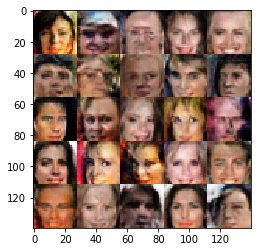

Epoch 1/1... Batch 4220/6331... Discriminator Loss: 1.1820... Generator Loss: 0.4885
Epoch 1/1... Batch 4240/6331... Discriminator Loss: 1.0392... Generator Loss: 0.7600
Epoch 1/1... Batch 4260/6331... Discriminator Loss: 1.4939... Generator Loss: 0.3540
Epoch 1/1... Batch 4280/6331... Discriminator Loss: 2.2995... Generator Loss: 0.1484
Epoch 1/1... Batch 4300/6331... Discriminator Loss: 1.8145... Generator Loss: 0.2354


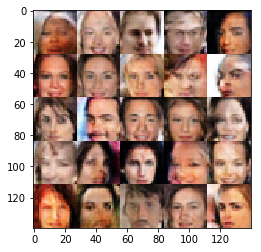

Epoch 1/1... Batch 4320/6331... Discriminator Loss: 0.9308... Generator Loss: 1.2844
Epoch 1/1... Batch 4340/6331... Discriminator Loss: 0.8412... Generator Loss: 0.7442
Epoch 1/1... Batch 4360/6331... Discriminator Loss: 1.1389... Generator Loss: 0.5177
Epoch 1/1... Batch 4380/6331... Discriminator Loss: 0.0956... Generator Loss: 3.9463
Epoch 1/1... Batch 4400/6331... Discriminator Loss: 1.0382... Generator Loss: 0.5332


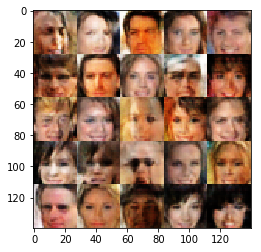

Epoch 1/1... Batch 4420/6331... Discriminator Loss: 1.6602... Generator Loss: 0.2664
Epoch 1/1... Batch 4440/6331... Discriminator Loss: 0.5089... Generator Loss: 1.1113
Epoch 1/1... Batch 4460/6331... Discriminator Loss: 0.9670... Generator Loss: 0.7249
Epoch 1/1... Batch 4480/6331... Discriminator Loss: 2.0024... Generator Loss: 0.1968
Epoch 1/1... Batch 4500/6331... Discriminator Loss: 0.9706... Generator Loss: 1.6643


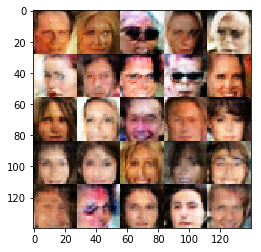

Epoch 1/1... Batch 4520/6331... Discriminator Loss: 0.8888... Generator Loss: 0.9784
Epoch 1/1... Batch 4540/6331... Discriminator Loss: 1.0398... Generator Loss: 1.1220
Epoch 1/1... Batch 4560/6331... Discriminator Loss: 0.8469... Generator Loss: 1.5283
Epoch 1/1... Batch 4580/6331... Discriminator Loss: 0.7439... Generator Loss: 0.8879
Epoch 1/1... Batch 4600/6331... Discriminator Loss: 1.3916... Generator Loss: 0.4153


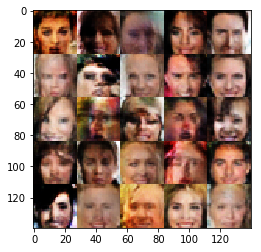

Epoch 1/1... Batch 4620/6331... Discriminator Loss: 0.6674... Generator Loss: 0.8653
Epoch 1/1... Batch 4640/6331... Discriminator Loss: 1.2989... Generator Loss: 0.5419
Epoch 1/1... Batch 4660/6331... Discriminator Loss: 1.3315... Generator Loss: 0.4037
Epoch 1/1... Batch 4680/6331... Discriminator Loss: 1.3371... Generator Loss: 0.9478
Epoch 1/1... Batch 4700/6331... Discriminator Loss: 1.1160... Generator Loss: 0.5892


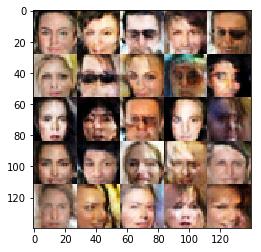

Epoch 1/1... Batch 4720/6331... Discriminator Loss: 1.3725... Generator Loss: 0.3979
Epoch 1/1... Batch 4740/6331... Discriminator Loss: 0.7266... Generator Loss: 3.2507
Epoch 1/1... Batch 4760/6331... Discriminator Loss: 0.3214... Generator Loss: 1.7150
Epoch 1/1... Batch 4780/6331... Discriminator Loss: 1.6881... Generator Loss: 0.2834
Epoch 1/1... Batch 4800/6331... Discriminator Loss: 1.1522... Generator Loss: 0.5149


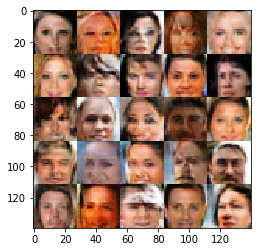

Epoch 1/1... Batch 4820/6331... Discriminator Loss: 2.2994... Generator Loss: 0.1486
Epoch 1/1... Batch 4840/6331... Discriminator Loss: 2.5913... Generator Loss: 0.1058
Epoch 1/1... Batch 4860/6331... Discriminator Loss: 0.7783... Generator Loss: 0.8807
Epoch 1/1... Batch 4880/6331... Discriminator Loss: 1.0651... Generator Loss: 0.4819
Epoch 1/1... Batch 4900/6331... Discriminator Loss: 0.8383... Generator Loss: 0.8176


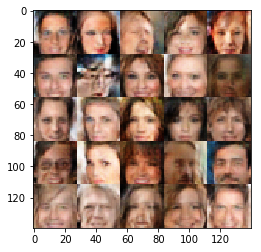

Epoch 1/1... Batch 4920/6331... Discriminator Loss: 1.1019... Generator Loss: 1.6302
Epoch 1/1... Batch 4940/6331... Discriminator Loss: 0.7366... Generator Loss: 1.5374
Epoch 1/1... Batch 4960/6331... Discriminator Loss: 0.4390... Generator Loss: 1.2724
Epoch 1/1... Batch 4980/6331... Discriminator Loss: 1.0137... Generator Loss: 0.7151
Epoch 1/1... Batch 5000/6331... Discriminator Loss: 1.9657... Generator Loss: 2.4126


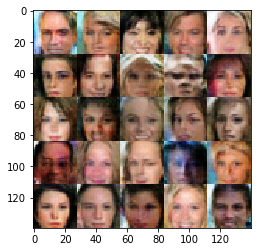

Epoch 1/1... Batch 5020/6331... Discriminator Loss: 1.7847... Generator Loss: 0.2353
Epoch 1/1... Batch 5040/6331... Discriminator Loss: 2.2636... Generator Loss: 0.1643
Epoch 1/1... Batch 5060/6331... Discriminator Loss: 1.2081... Generator Loss: 0.9290
Epoch 1/1... Batch 5080/6331... Discriminator Loss: 0.8474... Generator Loss: 0.8390
Epoch 1/1... Batch 5100/6331... Discriminator Loss: 0.2857... Generator Loss: 2.5789


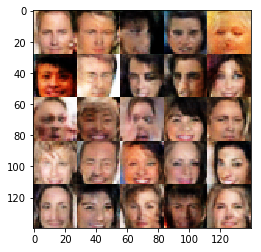

Epoch 1/1... Batch 5120/6331... Discriminator Loss: 0.2695... Generator Loss: 2.0877
Epoch 1/1... Batch 5140/6331... Discriminator Loss: 0.5414... Generator Loss: 1.1869
Epoch 1/1... Batch 5160/6331... Discriminator Loss: 2.3885... Generator Loss: 0.1608
Epoch 1/1... Batch 5180/6331... Discriminator Loss: 2.2546... Generator Loss: 0.1442
Epoch 1/1... Batch 5200/6331... Discriminator Loss: 1.5896... Generator Loss: 2.2991


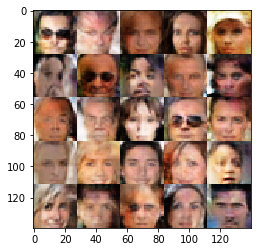

Epoch 1/1... Batch 5220/6331... Discriminator Loss: 0.6169... Generator Loss: 1.0433
Epoch 1/1... Batch 5240/6331... Discriminator Loss: 1.2596... Generator Loss: 0.4150
Epoch 1/1... Batch 5260/6331... Discriminator Loss: 1.1337... Generator Loss: 0.6092
Epoch 1/1... Batch 5280/6331... Discriminator Loss: 2.2815... Generator Loss: 2.5988
Epoch 1/1... Batch 5300/6331... Discriminator Loss: 0.5804... Generator Loss: 1.2295


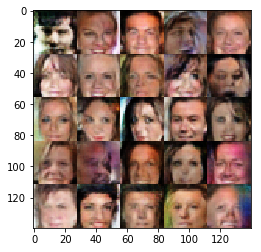

Epoch 1/1... Batch 5320/6331... Discriminator Loss: 0.2427... Generator Loss: 2.2417
Epoch 1/1... Batch 5340/6331... Discriminator Loss: 1.0335... Generator Loss: 0.6564
Epoch 1/1... Batch 5360/6331... Discriminator Loss: 0.5128... Generator Loss: 1.1895
Epoch 1/1... Batch 5380/6331... Discriminator Loss: 0.9993... Generator Loss: 2.0744
Epoch 1/1... Batch 5400/6331... Discriminator Loss: 1.8155... Generator Loss: 0.2735


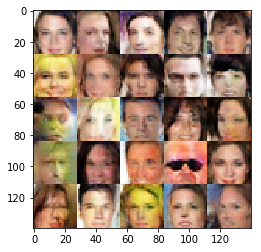

Epoch 1/1... Batch 5420/6331... Discriminator Loss: 0.3633... Generator Loss: 1.6197
Epoch 1/1... Batch 5440/6331... Discriminator Loss: 2.4798... Generator Loss: 0.1272
Epoch 1/1... Batch 5460/6331... Discriminator Loss: 2.3174... Generator Loss: 0.1539
Epoch 1/1... Batch 5480/6331... Discriminator Loss: 0.5683... Generator Loss: 1.0327
Epoch 1/1... Batch 5500/6331... Discriminator Loss: 0.9650... Generator Loss: 2.0569


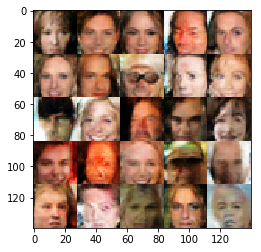

Epoch 1/1... Batch 5520/6331... Discriminator Loss: 2.5168... Generator Loss: 0.1114
Epoch 1/1... Batch 5540/6331... Discriminator Loss: 1.8624... Generator Loss: 0.2569
Epoch 1/1... Batch 5560/6331... Discriminator Loss: 0.9412... Generator Loss: 0.7266
Epoch 1/1... Batch 5580/6331... Discriminator Loss: 1.3629... Generator Loss: 0.3897
Epoch 1/1... Batch 5600/6331... Discriminator Loss: 0.8185... Generator Loss: 0.8105


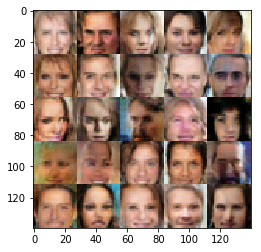

Epoch 1/1... Batch 5620/6331... Discriminator Loss: 2.5889... Generator Loss: 0.1146
Epoch 1/1... Batch 5640/6331... Discriminator Loss: 0.1570... Generator Loss: 2.6781
Epoch 1/1... Batch 5660/6331... Discriminator Loss: 1.3412... Generator Loss: 0.6594
Epoch 1/1... Batch 5680/6331... Discriminator Loss: 0.8844... Generator Loss: 0.7833
Epoch 1/1... Batch 5700/6331... Discriminator Loss: 1.0467... Generator Loss: 0.6611


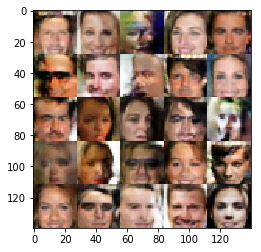

Epoch 1/1... Batch 5720/6331... Discriminator Loss: 1.1520... Generator Loss: 0.5635
Epoch 1/1... Batch 5740/6331... Discriminator Loss: 1.3252... Generator Loss: 0.4368
Epoch 1/1... Batch 5760/6331... Discriminator Loss: 0.9186... Generator Loss: 0.9276
Epoch 1/1... Batch 5780/6331... Discriminator Loss: 1.0878... Generator Loss: 2.7439
Epoch 1/1... Batch 5800/6331... Discriminator Loss: 1.2949... Generator Loss: 1.9126


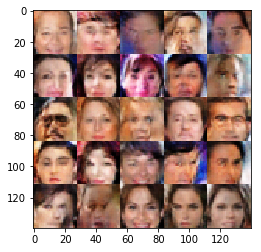

Epoch 1/1... Batch 5820/6331... Discriminator Loss: 0.9384... Generator Loss: 2.0980
Epoch 1/1... Batch 5840/6331... Discriminator Loss: 3.0491... Generator Loss: 0.0798
Epoch 1/1... Batch 5860/6331... Discriminator Loss: 1.0092... Generator Loss: 3.6745
Epoch 1/1... Batch 5880/6331... Discriminator Loss: 0.9398... Generator Loss: 0.7992
Epoch 1/1... Batch 5900/6331... Discriminator Loss: 0.7797... Generator Loss: 0.8408


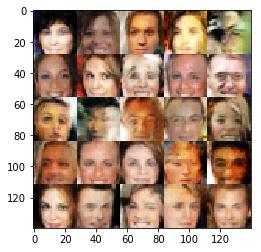

Epoch 1/1... Batch 5920/6331... Discriminator Loss: 0.7704... Generator Loss: 1.0575
Epoch 1/1... Batch 5940/6331... Discriminator Loss: 0.6881... Generator Loss: 1.0707
Epoch 1/1... Batch 5960/6331... Discriminator Loss: 0.9280... Generator Loss: 1.5611
Epoch 1/1... Batch 5980/6331... Discriminator Loss: 0.3965... Generator Loss: 1.9483
Epoch 1/1... Batch 6000/6331... Discriminator Loss: 1.5585... Generator Loss: 0.8081


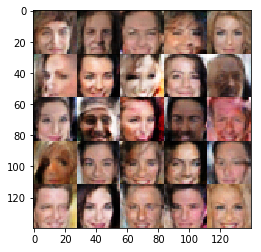

Epoch 1/1... Batch 6020/6331... Discriminator Loss: 1.4290... Generator Loss: 0.3932
Epoch 1/1... Batch 6040/6331... Discriminator Loss: 0.2908... Generator Loss: 1.8401
Epoch 1/1... Batch 6060/6331... Discriminator Loss: 0.4432... Generator Loss: 1.4414
Epoch 1/1... Batch 6080/6331... Discriminator Loss: 2.9136... Generator Loss: 0.0826
Epoch 1/1... Batch 6100/6331... Discriminator Loss: 1.9414... Generator Loss: 0.2012


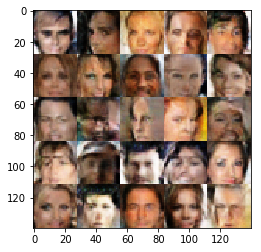

Epoch 1/1... Batch 6120/6331... Discriminator Loss: 1.1896... Generator Loss: 0.5269
Epoch 1/1... Batch 6140/6331... Discriminator Loss: 0.8934... Generator Loss: 0.7521
Epoch 1/1... Batch 6160/6331... Discriminator Loss: 0.4865... Generator Loss: 1.2678
Epoch 1/1... Batch 6180/6331... Discriminator Loss: 0.7026... Generator Loss: 0.9010
Epoch 1/1... Batch 6200/6331... Discriminator Loss: 0.4717... Generator Loss: 1.2972


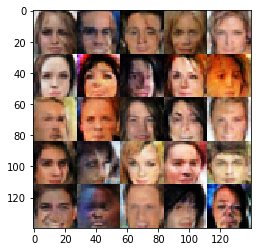

Epoch 1/1... Batch 6220/6331... Discriminator Loss: 1.0072... Generator Loss: 0.7015
Epoch 1/1... Batch 6240/6331... Discriminator Loss: 0.6156... Generator Loss: 1.1842
Epoch 1/1... Batch 6260/6331... Discriminator Loss: 1.8530... Generator Loss: 2.0079
Epoch 1/1... Batch 6280/6331... Discriminator Loss: 1.4322... Generator Loss: 0.3838
Epoch 1/1... Batch 6300/6331... Discriminator Loss: 2.7173... Generator Loss: 0.1117


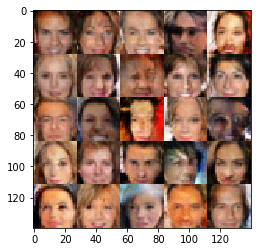

Epoch 1/1... Batch 6320/6331... Discriminator Loss: 2.4235... Generator Loss: 0.1157


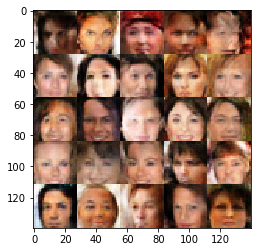

In [314]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.